# Initial Analysis

The plots below were obtained under the following conditions:

* Small, CNN Model
* Cifar-10 dataset
* Batchsize 128
* 2 epochs of training
* 0.2 second sampling intervals
* Training done on a single CPU

A struct was used to collect some meaningful data during execution. Data collected for each sample interval includes:

* Number of virtual page frames resident in memory (but not necessarily active)
* Number of vitrual page frames marked as active (i.e. working set size)
* The total size of all the Virtual Memory Areas (VMAs) allocated to this process.
* The maximum stack depth of a page frame accessed.

In addition, the `distance` field of the struct is of type `Dict{Int,Int}` where the keys are depth in the stack and values are the number of times that depth was seen.

In [1]:
# Add plots library
using Plots
pyplot() # Use PyPlot (aka matplotlib) backend

# Activate the environment in the "Launcher" project folder
using Pkg
Pkg.activate("../../Launcher")

# Import the Launcher module
using Launcher

# Deserialize the tracker struct that was used to record various metrics from a run.
tracker = Launcher.load("cifar_cnn_basic.jls");

## Plot of various working sizes

We have three measures of memory use:

* The total address space of VMAs assigned to Tensorflow process (not every virtual address in this space is necessarily materialized into a physical page resident in memory)
* The virtual pages that are resident in memory but not necessarily active
* The virtual pages that are actually marked as active

Below, we plot the total amount of memory in each category on the same plot.

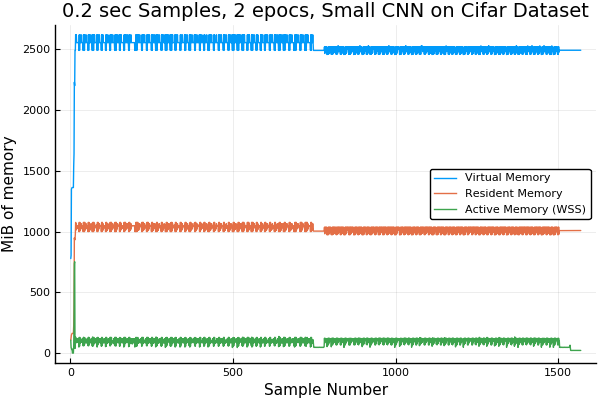

In [2]:
plot(tracker.vma_size ./ (1024 * 1024), lab = "Virtual Memory")
plot!(size_mb(tracker.resident_pages), lab = "Resident Memory")
plot!(size_mb(tracker.active_pages), lab = "Active Memory (WSS)")

# Setup some plot labels
title!("0.2 sec Samples, 2 epocs, Small CNN on Cifar Dataset")
xlabel!("Sample Number")
ylabel!("MiB of memory")

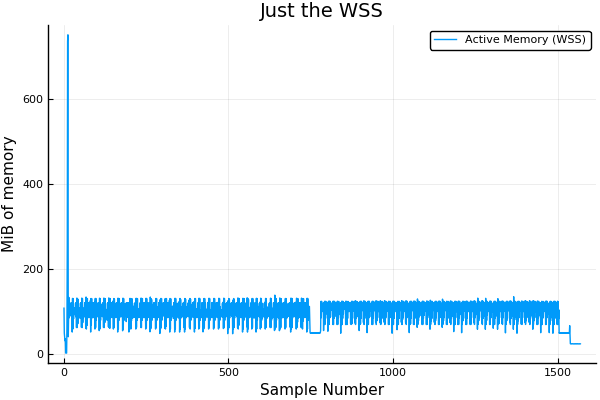

In [3]:
plot(size_mb(tracker.active_pages), lab = "Active Memory (WSS)")
title!("Just the WSS")
xlabel!("Sample Number")
ylabel!("MiB of memory")

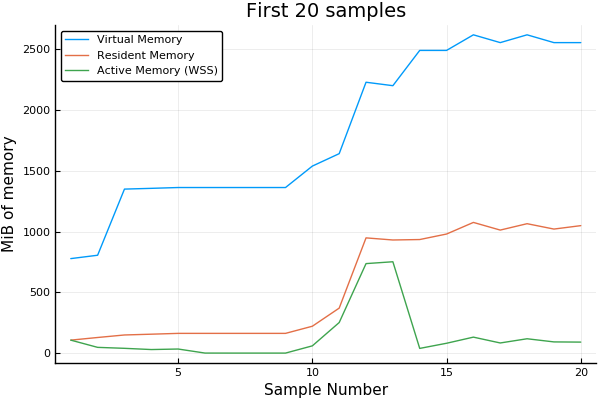

In [4]:
# Take a closer look at at what happens in the beginning
N = 20 # Take the first N samples

plot((tracker.vma_size ./ (1024 * 1024))[1:N], lab = "Virtual Memory")
plot!(size_mb(tracker.resident_pages)[1:N], lab = "Resident Memory")
plot!(size_mb(tracker.active_pages)[1:N], lab = "Active Memory (WSS)")

# Setup some plot labels
title!("First $N samples")
xlabel!("Sample Number")
ylabel!("MiB of memory")

Some takeaways:

1. The total amount of virtual memory belonging to the application is much greater than the amound of memory that is actually *present* in DRAM (not too surprising)
2. I'm not entirely sure why there is so much noise in all three samples.
3. The WSS of this application was fairly static once it was training. What is interesting is that (as shown below), the average WSS during training was only around 100 MB. However, the size of the dataset (which gets converted from UInt8 to Float32) is 50000 * 32 * 32 * 3 * 4 > 600 MB. So, the WSS is much smaller than the combined size of the model and data.

In [5]:
# Average WSS size over 0.2 seconds
mean(size_mb.(tracker.active_pages))

UndefVarError: UndefVarError: mean not defined

# Reuse Distance

A stack-based reuse distance analysis was conducted on the page frame access patterns. (Write up on this TODO). From this analysis, we can generate a CDF plot where the x-axis represents the size of a memory and the y-axis represents the probability that a memory reference will reside within memory (i.e., will not have been evicted ... under some assumptions about LRUish eviction policies)

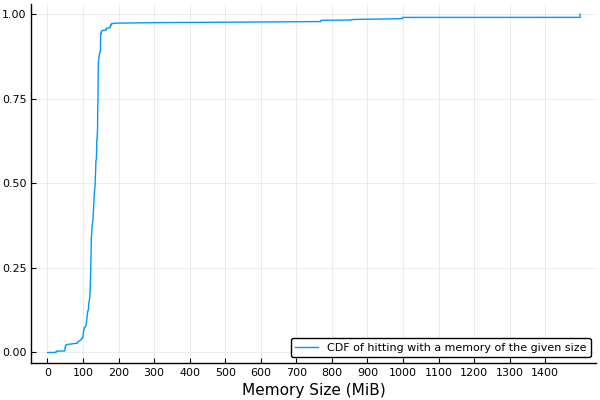

In [6]:
# Use some methods inside MemSnoop.jl to transform the "distance" dictionary into a more useful form for plotting
# The way this is 
cdf = make_cdf(tracker)
memory = memory_vec(cdf)

plot(memory, cdf, lab = "CDF of hitting with a memory of the given size")
xlabel!("Memory Size (MiB)")
xticks!(0:100:last(memory))

Lets zoom in on the a little bit.

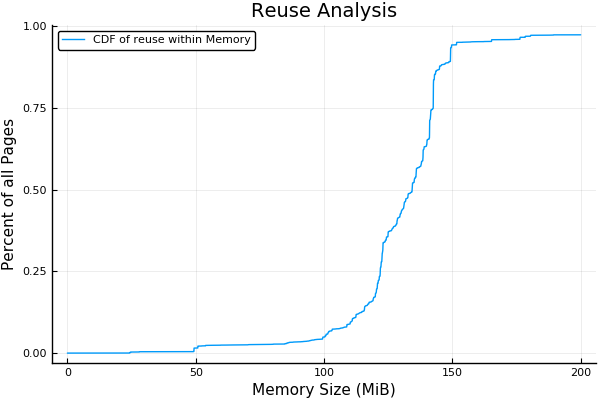

In [7]:
ind = findfirst(x -> x > 200, memory)

plot(memory[1:ind], cdf[1:ind], lab = "CDF of reuse within Memory")
title!("Reuse Analysis")
xlabel!("Memory Size (MiB)")
ylabel!("Percent of all Pages")

Another way of viewing this is to transpose the CDF and make the memory use logarithmic.

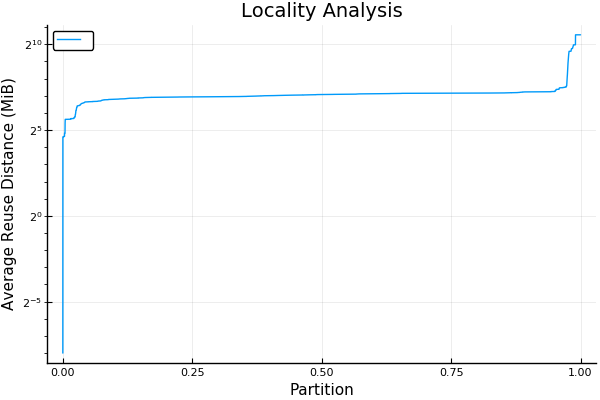

In [8]:
plot(cdf, memory, yscale = :log2, lab=nothing)
title!("Locality Analysis")
xlabel!("Partition")
ylabel!("Average Reuse Distance (MiB)")

This shows that (almost) every single page is accesses within 200 MB of the last time it was accessed. Thus, if you had a cache of 200 MB, you would get almost a 100% hit rate.

### Analysis

The results are not too surprising - the CDF increases until the memory is large enough to hold the entire working dataset in memory, then flattens out. I think that what is interesting here is that the WSS analysis implies that at any given period of time, we can get away with less memory.

Things to consider:

I'm sampling over a 0.2 second window. That is:

1. Mark all pages as idle
2. Run application for 0.2 seconds
3. Pause application
4. Check active pages
5. Repeat

This coarse grained approach can lead to some noise.

## Further Questions

1. WHAT exactly is the WSS made of. Is it model data? Image data? What fraction of each? How do we figure this out?
2. How do these plots change for different batch sizes, and for comparing RESNET.
3. How much is sample time influencing the results we see. Maybe plot WSS as a function of sample time?

# Checking if Docker is fuzzing the samples

Lets look at what happens when we just launch the docker container with no Python process running.

In [9]:
tracker = open(deserialize, "docker.jls");

plot(tracker.vma_size ./ (1024 * 1024), lab = "Virtual Memory")
plot!(size_mb(tracker.resident_pages), lab = "Resident Memory")
plot!(size_mb(tracker.active_pages), lab = "Active Memory (WSS)")

# Setup some plot labels
title!("Memory overhead of just launching Docker")
xlabel!("Sample Number")
ylabel!("MiB of memory")

UndefVarError: UndefVarError: deserialize not defined

What about launching Python and importing all of the Keras libraries, but not running any workload

In [10]:
tracker = open(deserialize, "python.jls");

plot(tracker.vma_size ./ (1024 * 1024), lab = "Virtual Memory")
plot!(size_mb(tracker.resident_pages), lab = "Resident Memory")
plot!(size_mb(tracker.active_pages), lab = "Active Memory (WSS)")

# Setup some plot labels
title!("Memory overhead of just launching Python in Docker")
xlabel!("Sample Number")
ylabel!("MiB of memory")

UndefVarError: UndefVarError: deserialize not defined

## Analysis

It seems that the overhead for Docker or launching Python is pretty insignificant.

# Memory Visualization
To visualize the regions of memory that are accessed over time, a full trace was recorded over 1 epoch of training with 0.5 sec sample windows. Below are the two heatmaps.

To translate these,
* x-axis is sample number
* y-axis is ordered by increasing virtual addresses
* Yellow means a page was active, black means idle

### Python Heap
![image](./heap.png)

### Whole Trace
![image](./plot.png)
Here's the total address space. I think the following reagons are as follows (from bottom to top)
1. Python Heap
2. Some Tensorflow workspace??
3. Where the model lives?
4. Training Dataset (large, sparse region)
5. Validation Dataset (upward stripes)
6. ???
7. Stack